In [1]:
import pandas as pd
pd.set_option("display.max_columns", 100)
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

CSV_DATA = Path().cwd().parent.parent / "data/2_loaded"

In [2]:
df = pd.read_csv(CSV_DATA/'summary/ride_summary_good.csv')
df['start_date'] = pd.to_datetime(df['start_date'])
df['year'] = df['start_date'].dt.year
df['month'] = df['start_date'].dt.month
df['month_name'] = df['start_date'].dt.month_name()
df['start_time'] = pd.to_timedelta(df['start_time'])
df['end_time'] = pd.to_timedelta(df['end_time'])

In [3]:
power_cols = ['best_power_4s', 'best_power_5s','best_power_10s', 'best_power_20s', 'best_power_30s', 'best_power_1m',
                    'best_power_2m', 'best_power_3m', 'best_power_4m', 'best_power_5m',
                    'best_power_6m', 'best_power_10m', 'best_power_20m', 'best_power_30m',
                    'best_power_40m', 'best_power_1h']

In [4]:
import re
def get_power_curves(df_summary:pd.DataFrame, ride_id_subset:list[str]=None) -> pd.DataFrame:
    # Subset the df_summary columns and filter for the relevant ride_ids
    cols_of_interest = ['ride_id', 'start_date','year','month','month_name', 'total_distance_mi','total_ascent_ft','avg_power']
    power_cols = ['best_power_4s', 'best_power_5s','best_power_10s', 'best_power_20s', 'best_power_30s', 'best_power_1m',
                    'best_power_2m', 'best_power_3m', 'best_power_4m', 'best_power_5m',
                    'best_power_6m', 'best_power_10m', 'best_power_20m', 'best_power_30m',
                    'best_power_40m', 'best_power_1h']
    cols_of_interest += power_cols
    if ride_id_subset is None: ride_id_subset = df['ride_id'].values # if not specified, all rides will be used
    df_rides = df_summary.copy().loc[df_summary['ride_id'].isin(ride_id_subset), cols_of_interest]

    # Create a mapping from power column names back to axis labels and values
    power_col_map = get_power_column_mapping(power_cols)

    # For each ride, plot its power curve
    df_powers = []
    for _, row in df_rides.iterrows():
        data = [{'duration':power_col_map[col]['duration'], 'best_power':row[col]} for col in power_cols]
        df_pwr = pd.DataFrame(data)
        df_pwr['ride_id']=row['ride_id']
        df_pwr['year']=row['year']
        df_pwr['month']=row['month']
        df_pwr['month_name']=row['month_name']
        df_pwr = df_pwr[['ride_id','year','month','month_name','duration','best_power']]
        df_powers.append(df_pwr)

    return pd.concat(df_powers, ignore_index=True)

def get_power_column_mapping(power_cols:list[str]) -> dict:
    # Create a mapping from power column names back to axis labels and values
    pattern = r'best_power_([\d]+)([smh])'
    seconds_map = {'s':1, 'm':60, 'h':60*60}
    power_col_map = dict()
    for col in power_cols:
        matched = re.match(pattern, col)
        if matched is not None:
            value, unit = matched.groups()
            power_col_map[col] = {'label':value+unit,'duration':int(value)*seconds_map[unit]}
    return power_col_map

def get_top_cyclists_power_curve() -> pd.DataFrame:
    power_col_map = get_power_column_mapping(power_cols)
    # top 1% of cyclists, ref: https://www.cyclinganalytics.com/blog/2018/06/how-does-your-cycling-power-output-compare
    top_cyclist_powers = {'best_power_4s':1650, 'best_power_5s':1500,'best_power_10s':1375, 'best_power_20s':1200, 'best_power_30s':1000, 'best_power_1m':775,
                        'best_power_2m':600, 'best_power_3m':560, 'best_power_4m':535, 'best_power_5m':510,
                        'best_power_6m':500, 'best_power_10m':490, 'best_power_20m':460, 'best_power_30m':420,
                        'best_power_40m':375, 'best_power_1h':360}
    data = [{'duration':power_col_map[col]['duration'], 'best_power':top_cyclist_powers[col]} for col in top_cyclist_powers.keys()]
    df_pwr_top = pd.DataFrame(data)
    return df_pwr_top

In [5]:
def plot_summary_power_curves(df_pwrs:pd.DataFrame, figsize:tuple=(12,4), color_by:str='ride_id', alpha:float=0.5, ylims:list[float]=None,
                              logscale_base:int=10, title:str='Best Ride Efforts Power Curve', show_best_cyclist_curve:bool=True):
    ########################################################################
    # Create the Figure
    fig, ax = plt.subplots(1,1, figsize=figsize)

    # For each ride, plot its power curve
    plot_kwargs = dict(data=df_pwrs, x='duration', y='best_power', ax=ax, alpha=alpha,legend=False, hue=color_by)
    if color_by!='ride_id':
        plot_kwargs['legend']=True
        plot_kwargs['palette']='tab10'
    _ = sns.lineplot(**plot_kwargs)
    plot_kwargs['legend']=False # do not record dots in the legend
    _ = sns.scatterplot(**plot_kwargs)
    

    if show_best_cyclist_curve:
        df_pwr_top = get_top_cyclists_power_curve()
        _ = ax.plot(df_pwr_top['duration'],df_pwr_top['best_power'], alpha=0.8, c='red', linestyle='--')
        _ = ax.scatter(df_pwr_top['duration'],df_pwr_top['best_power'],label='Top 99% Cyclist', alpha=0.8, marker='d', c='red', linewidths=2)
        _ = plt.legend(loc='best')
    

    ########################################################################
    # Set the axes up for plotting
    def forward(x):
        return np.log10(x) / np.log10(logscale_base)

    def inverse(x):
        return logscale_base**x
    
    if logscale_base==10:
        _ = ax.set_xscale('log')
    else:
        _ = ax.set_xscale('function', functions=(forward,inverse))
    power_col_map = get_power_column_mapping(power_cols)
    _ = plt.xticks(ticks=[col['duration'] for col in power_col_map.values()], 
                   labels=[col['label'] for col in power_col_map.values()], rotation=45)
    _ = plt.grid()
    _ = ax.set_axisbelow(True)
    _ = plt.xlabel('Effort Time Duration', fontsize=14)
    _ = plt.ylabel('Maximum Effort Power (W)', fontsize=14)
    _ = plt.title(title, fontsize=18)
    _ = plt.legend(bbox_to_anchor=(1.025, 1), loc='upper left')
    _ = plt.tight_layout()
    if ylims is not None:
        _ = plt.ylim(ylims)

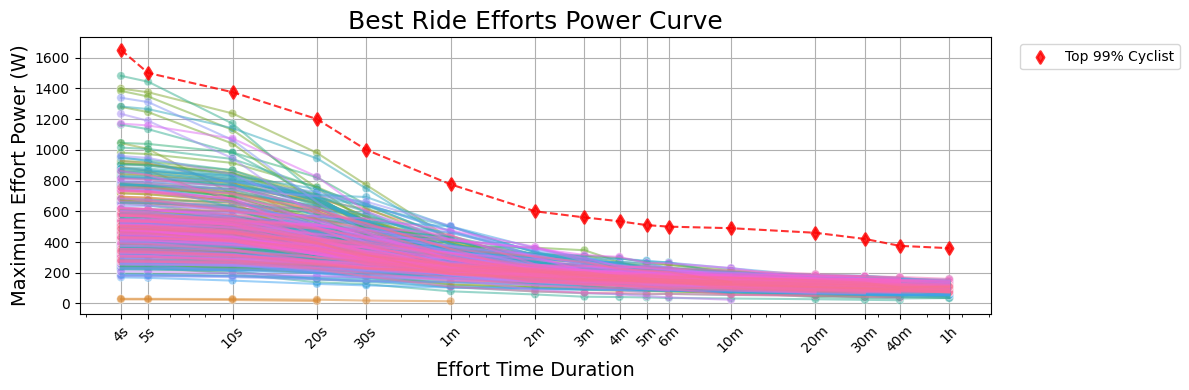

In [6]:
df_pwrs = get_power_curves(df_summary=df)
plot_summary_power_curves(df_pwrs=df_pwrs)

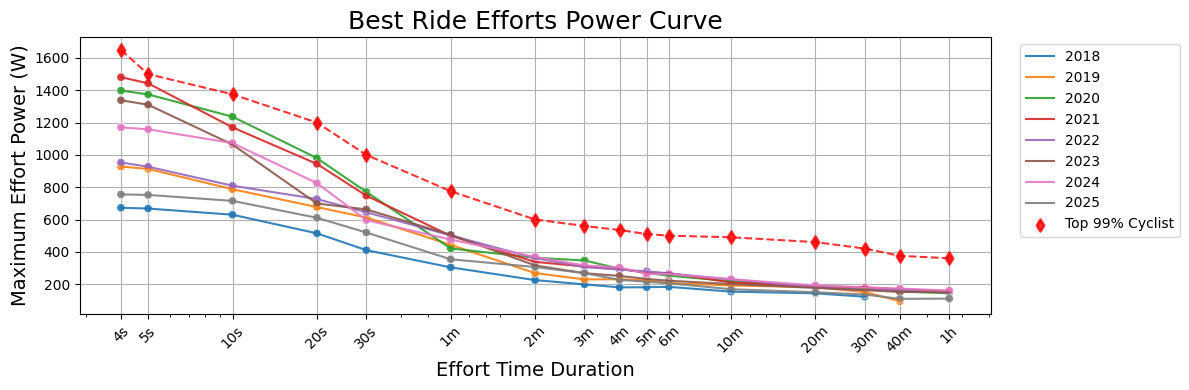

In [7]:
df_pwrs_by_year = df_pwrs[['year','duration','best_power']].groupby(['year','duration']).max()
plot_summary_power_curves(df_pwrs=df_pwrs_by_year, color_by='year', alpha=0.9, ylims=None)

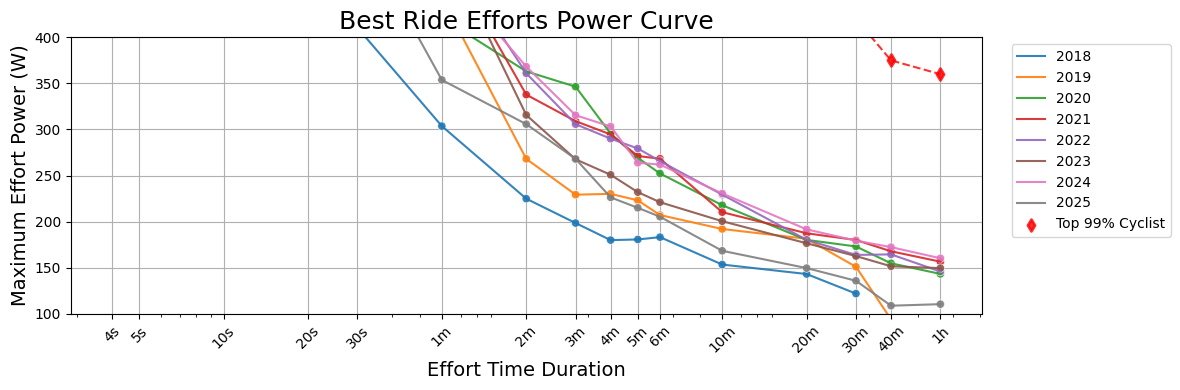

In [8]:
plot_summary_power_curves(df_pwrs=df_pwrs_by_year, color_by='year', alpha=0.9, ylims=[100,400])

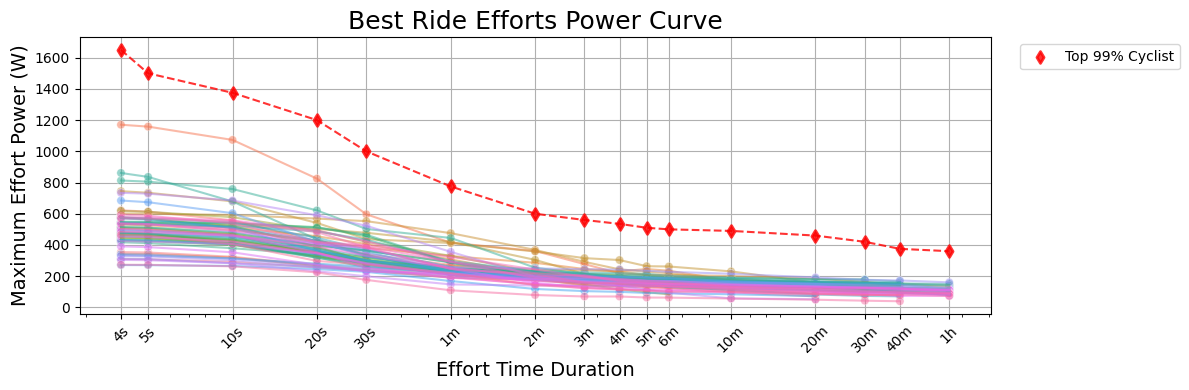

In [9]:
df_pwrs_2024 = df_pwrs.loc[df_pwrs['year']==2024,:]
plot_summary_power_curves(df_pwrs=df_pwrs_2024)

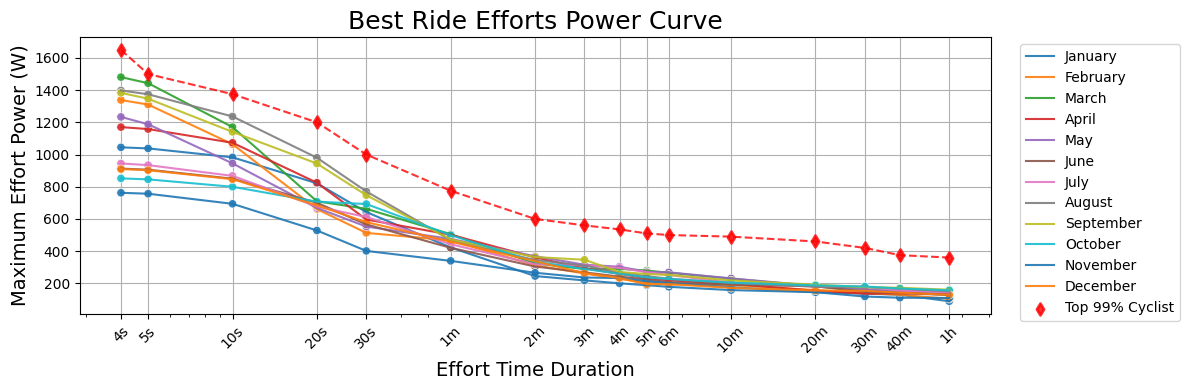

In [10]:
df_pwrs_2024_by_month = df_pwrs[['month','month_name','duration','best_power']].groupby(['month','month_name','duration']).max()
plot_summary_power_curves(df_pwrs=df_pwrs_2024_by_month, color_by='month_name', alpha=0.9, ylims=None)

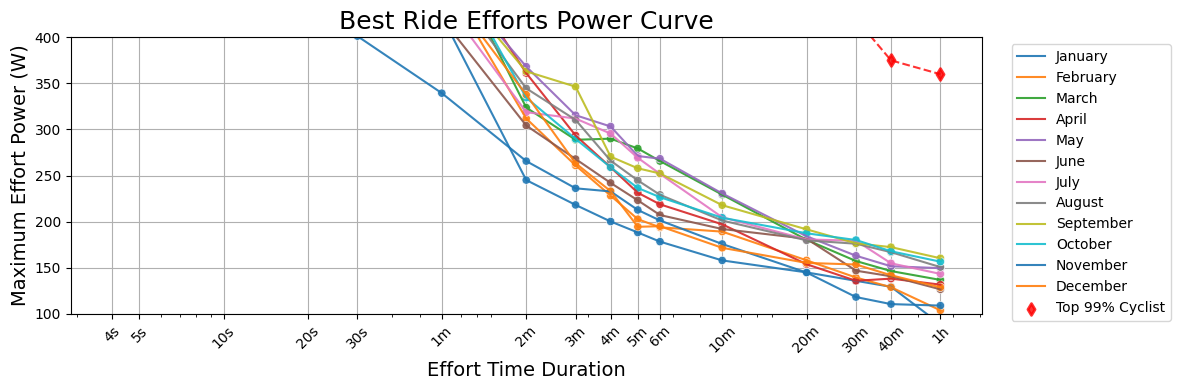

In [11]:
plot_summary_power_curves(df_pwrs=df_pwrs_2024_by_month, color_by='month_name', alpha=0.9, ylims=[100,400])

In [22]:
df_pwr_pivot = pd.pivot_table(df_pwrs_2024_by_month.reset_index(), values='best_power', columns='month_name', index='duration')

In [23]:
df_pwr_pivot

month_name,April,August,December,February,January,July,June,March,May,November,October,September
duration,,,,,,,,,,,,
4,1170.473521,1398.224247,909.737545,1338.372486,1044.763411,944.644204,912.663313,1480.983782,1233.740162,762.361723,851.920700,1383.299073
5,1158.334870,1374.422445,902.712335,1310.665541,1038.135940,934.317478,905.961699,1443.086737,1188.111138,756.600587,845.776563,1346.736218
10,1073.148701,1236.596746,846.824615,1064.100827,982.640555,867.526236,850.114702,1170.371624,945.222789,693.909476,799.702216,1140.629236
20,825.049190,980.134490,684.309996,661.109139,821.280891,676.947693,700.537274,709.638168,668.348386,528.371238,707.177589,944.183332
30,596.478742,770.898848,580.036078,513.293785,642.568898,612.181423,565.991337,662.666780,552.564718,401.296153,692.591566,747.484722
60,501.700093,468.710805,458.758436,466.739507,422.844459,442.957999,420.486590,505.080407,475.708726,339.421786,499.246767,472.324379
120,361.223633,344.647057,337.814391,311.916502,245.117421,318.796740,304.294777,323.773888,368.238988,265.710125,334.529557,363.075650
180,293.492653,310.406351,263.357335,260.972111,218.147573,311.868159,267.960737,288.840033,315.488671,236.176040,289.739062,346.435987
240,258.980268,266.163110,233.063888,228.184213,200.167071,295.515421,242.012903,290.036696,303.259288,232.787425,258.937434,270.499137


In [24]:
month_number= {'January':1,'February':2,'March':3,'April':4,'May':5,'June':6,'July':7,'August':8,'September':9,'October':10,'November':11,'December':12}
df_pwr_pivot = df_pwr_pivot[month_number.keys()]

month_name,January,February,March,April,May,June,July,August,September,October,November,December
duration,,,,,,,,,,,,
4,1044.763411,1338.372486,1480.983782,1170.473521,1233.740162,912.663313,944.644204,1398.224247,1383.299073,851.920700,762.361723,909.737545
5,1038.135940,1310.665541,1443.086737,1158.334870,1188.111138,905.961699,934.317478,1374.422445,1346.736218,845.776563,756.600587,902.712335
10,982.640555,1064.100827,1170.371624,1073.148701,945.222789,850.114702,867.526236,1236.596746,1140.629236,799.702216,693.909476,846.824615
20,821.280891,661.109139,709.638168,825.049190,668.348386,700.537274,676.947693,980.134490,944.183332,707.177589,528.371238,684.309996
30,642.568898,513.293785,662.666780,596.478742,552.564718,565.991337,612.181423,770.898848,747.484722,692.591566,401.296153,580.036078
60,422.844459,466.739507,505.080407,501.700093,475.708726,420.486590,442.957999,468.710805,472.324379,499.246767,339.421786,458.758436
120,245.117421,311.916502,323.773888,361.223633,368.238988,304.294777,318.796740,344.647057,363.075650,334.529557,265.710125,337.814391
180,218.147573,260.972111,288.840033,293.492653,315.488671,267.960737,311.868159,310.406351,346.435987,289.739062,236.176040,263.357335
240,200.167071,228.184213,290.036696,258.980268,303.259288,242.012903,295.515421,266.163110,270.499137,258.937434,232.787425,233.063888
